# Global Green Energy Part 8: CO2 Emissions Clustering & Analysis 🌡️

This specialized analysis focuses on CO2 emissions patterns through clustering and temporal analysis. We apply K-means clustering to group countries by emission levels, handle outliers systematically, and examine emissions trajectories within homogeneous country groups. This approach reveals distinct emission archetypes and temporal patterns that inform climate policy and transition strategies.

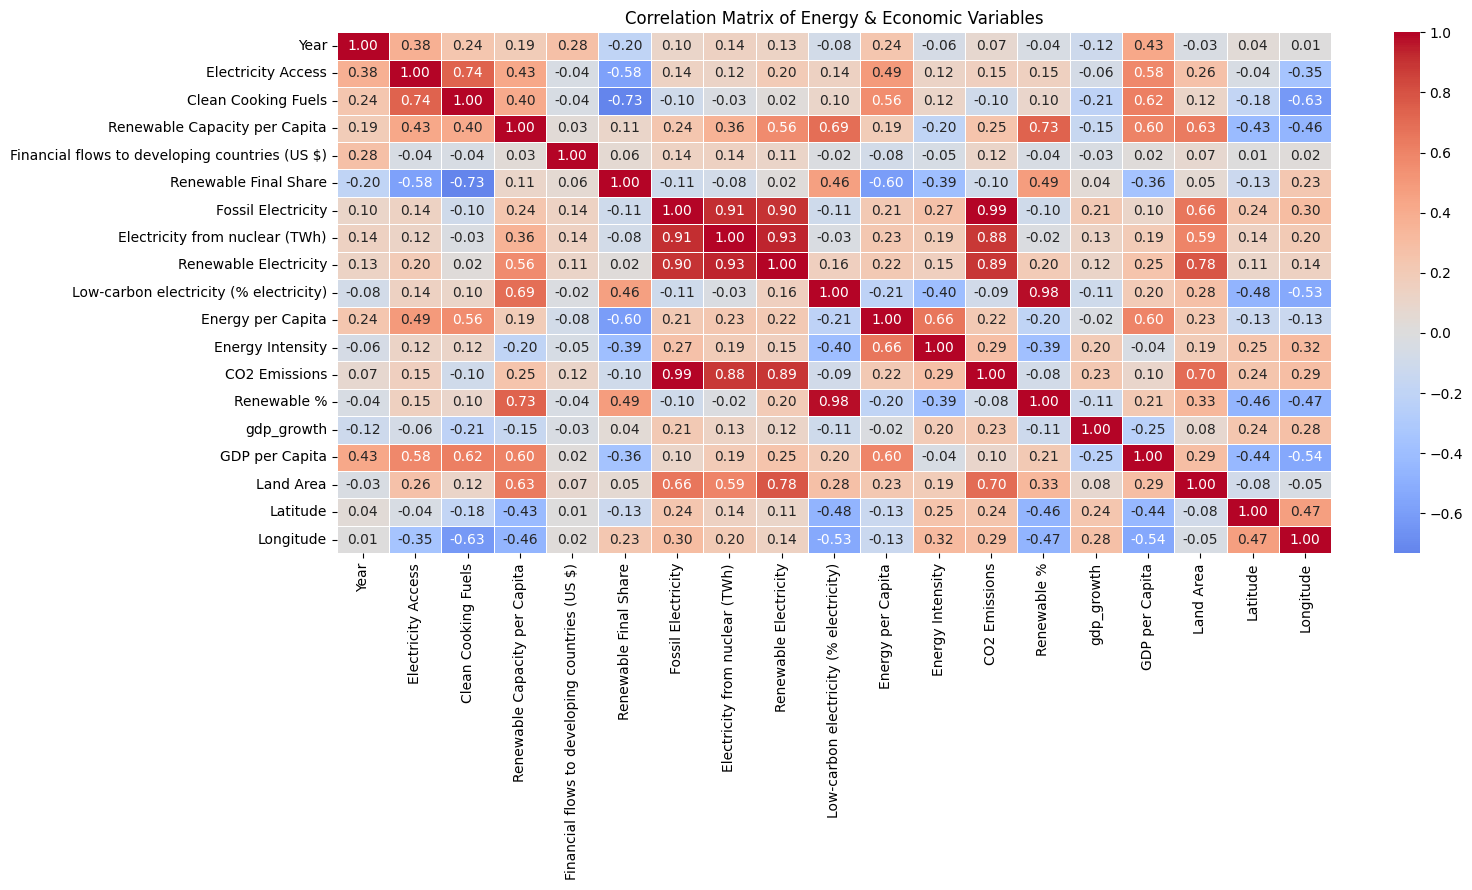

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from math import sqrt

# Load in data
raw_data = pd.read_csv('../day18/global_sustainable_energy_data.csv')
df = raw_data.copy()

# Select only numeric columns
df_num = df.select_dtypes(include="number")

# Drop missing values (or fillna if needed)
df_corr = df_num.dropna()

# Correlation matrix
corr_matrix = df_corr.corr()

# Rename variable names
var_name_mapping = {
    'Electricity from fossil fuels (TWh)': 'Fossil Electricity',
    'Electricity from renewables (TWh)': 'Renewable Electricity', 
    'Energy intensity level of primary energy (MJ/$2017 PPP GDP)': 'Energy Intensity',
    'Primary energy consumption per capita (kWh/person)': 'Energy per Capita',
    'Renewables (% equivalent primary energy)': 'Renewable %',
    'Value_co2_emissions_kt_by_country': 'CO2 Emissions',
    'gdp_per_capita': 'GDP per Capita',
    'Access to electricity (% of population)': 'Electricity Access',
    'Access to clean fuels for cooking': 'Clean Cooking Fuels',
    'Land Area(Km2)': 'Land Area',
    'Renewable-electricity-generating-capacity-per-capita': 'Renewable Capacity per Capita',
    'Renewable energy share in the total final energy consumption (%)': 'Renewable Final Share',
}

# Apply renaming to rows and columns in correlation matrix
corr_matrix.rename(index=var_name_mapping, columns=var_name_mapping, inplace=True)

# Plot
plt.figure(figsize=(16, 9))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    linewidths=0.5
)
plt.title("Correlation Matrix of Energy & Economic Variables")
plt.tight_layout()
plt.show()

## Emissions in Context: Correlation Foundation

The enhanced correlation matrix with cleaner variable names reveals CO2 emissions relationships across the energy-economic system:
- **Emissions drivers identification** - understanding which variables correlate most strongly with CO2 emissions helps identify the primary levers for emissions reduction
- **System interconnections** - the correlation patterns show how emissions connect to economic development, energy choices, and infrastructure development, providing insights for integrated climate-energy policy design

Missing data through the entire dataset. Drop those rows.


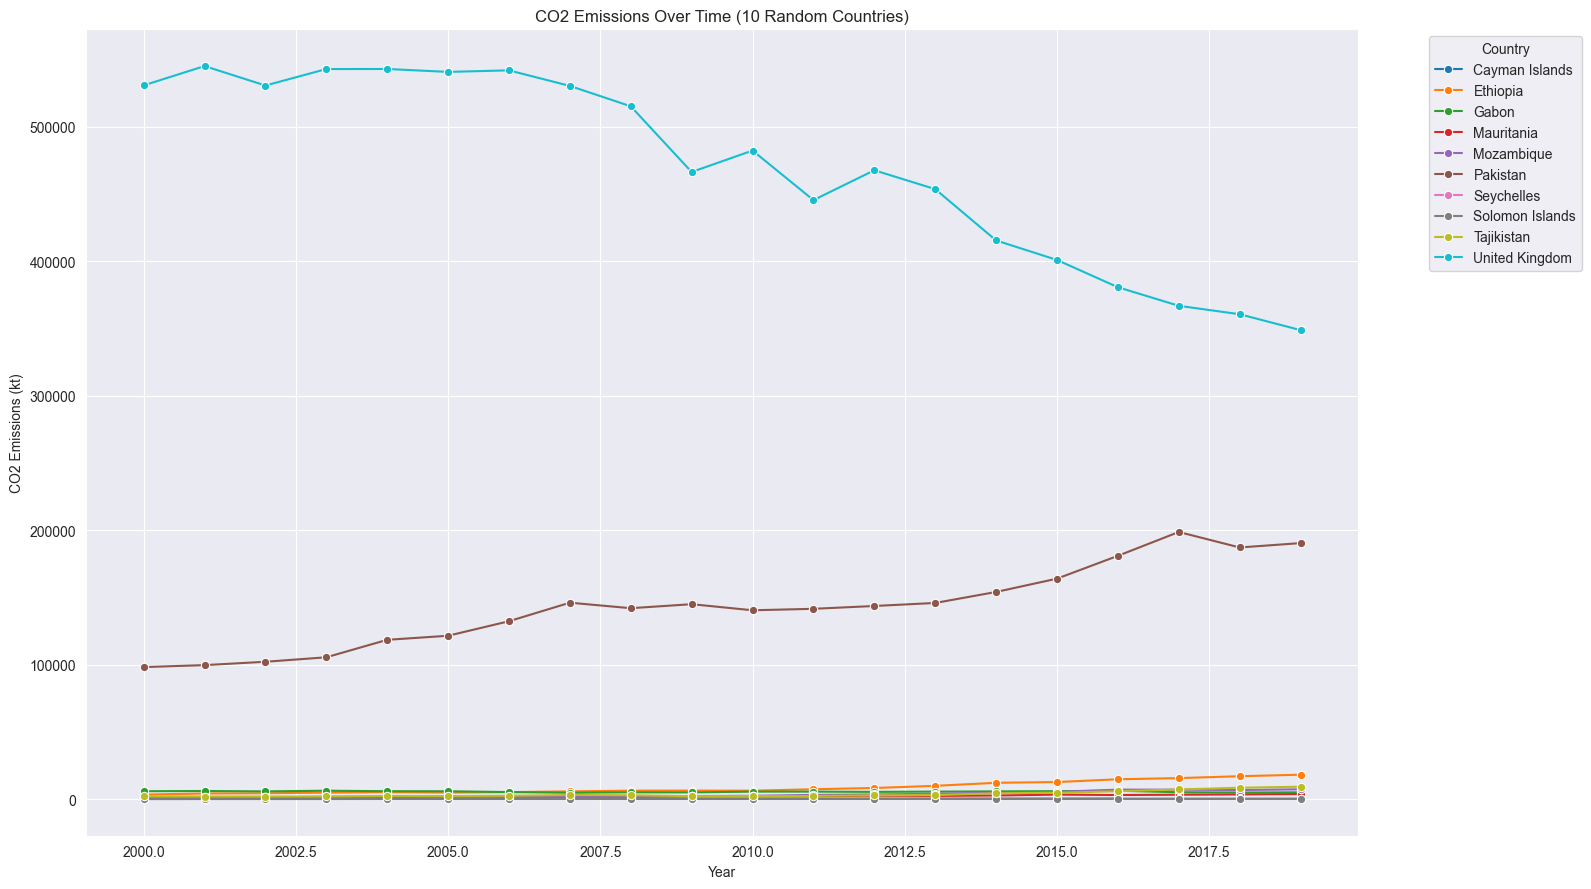

In [43]:
# rename df columns as above
df.rename(columns=var_name_mapping, inplace=True)

# handle missing values in 'CO2 Emissions'
missing_co2 = df[df['CO2 Emissions'].isnull()]
missing_co2.groupby(['Year']).size().reset_index(name='Count')
print("Missing data through the entire dataset. Drop those rows.")
df_co2 = df[df['CO2 Emissions'].notna()]

# sample 10 random countries
sample_countries = df_co2['Entity'].drop_duplicates().sample(10, random_state=42).tolist()

# Filter data to sampled countries
df_sample = df_co2[df_co2['Entity'].isin(sample_countries)]

# build the plot
sns.set_style("darkgrid")
plt.figure(figsize=(16, 9))
sns.lineplot(
    data=df_sample,
    x='Year',
    y='CO2 Emissions',
    hue='Entity',
    marker='o'
)

plt.title("CO2 Emissions Over Time (10 Random Countries)")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (kt)")
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Initial Emissions Exploration: Random Country Sampling

The random sample of 10 countries provides an unbiased first look at CO2 emissions temporal patterns:
- **Diversity of trajectories** - random sampling reveals the wide variety of emissions pathways across different countries, from steady growth to declining trends to volatile patterns
- **Data quality assessment** - examining temporal trends in a random sample helps identify data completeness issues and establishes baseline expectations for more sophisticated clustering analysis

In [66]:
# Step 1: CO2 average per country
df_co2 = df[['Entity', 'CO2 Emissions']].dropna()
avg_emissions = df_co2.groupby('Entity')['CO2 Emissions'].mean().reset_index()
avg_emissions.columns = ['Entity', 'Avg_CO2']

# Step 2: Filter top 5% outliers
threshold = avg_emissions['Avg_CO2'].quantile(0.95)
filtered_avg = avg_emissions[avg_emissions['Avg_CO2'] <= threshold].copy()

# Step 3: KMeans (more clusters than needed to catch outliers)
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
filtered_avg['Cluster'] = kmeans.fit_predict(filtered_avg[['Avg_CO2']])

# Step 4: Merge clusters with <3 countries into nearest larger cluster
cluster_sizes = filtered_avg['Cluster'].value_counts()
small_clusters = cluster_sizes[cluster_sizes < 3].index.tolist()

# Compute centroids
centroids = filtered_avg.groupby('Cluster')['Avg_CO2'].mean()

for small in small_clusters:
    small_rows = filtered_avg[filtered_avg['Cluster'] == small]
    for i, row in small_rows.iterrows():
        # Find closest large cluster
        distances = abs(centroids - row['Avg_CO2'])
        distances = distances.drop(small_clusters)  # avoid other small clusters
        new_cluster = distances.idxmin()
        filtered_avg.at[i, 'Cluster'] = new_cluster

# Step 5: Recompute cluster summary
final_clusters = filtered_avg.groupby('Cluster')['Avg_CO2'].agg(['count', 'min', 'max']).reset_index()

# Sort clusters by average CO₂
sorted_clusters = (
    filtered_avg.groupby('Cluster')['Avg_CO2']
    .mean()
    .sort_values()
    .index.tolist()
)

# Step 6: Show summary
for cluster_id in sorted_clusters:
    group = filtered_avg[filtered_avg['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id}:")
    print(f"- Countries ({len(group)}): {', '.join(group['Entity'].tolist()[:10])}...")
    print(f"- Avg CO₂ Range: {group['Avg_CO2'].min():,.0f} to {group['Avg_CO2'].max():,.0f} kt")



Cluster 0:
- Countries (84): Afghanistan, Albania, Antigua and Barbuda, Armenia, Aruba, Barbados, Belize, Benin, Bermuda, Bhutan...
- Avg CO₂ Range: 10 to 11,763 kt

Cluster 5:
- Countries (22): Angola, Azerbaijan, Bahrain, Bosnia and Herzegovina, Croatia, Cuba, Dominican Republic, Ecuador, Estonia, Guatemala...
- Avg CO₂ Range: 12,403 to 37,555 kt

Cluster 4:
- Countries (25): Austria, Bangladesh, Belarus, Bulgaria, Chile, Colombia, Denmark, Finland, Greece, Hungary...
- Avg CO₂ Range: 40,949 to 85,538 kt

Cluster 2:
- Countries (11): Algeria, Argentina, Belgium, Czechia, Iraq, Netherlands, Nigeria, Pakistan, Philippines, United Arab Emirates...
- Avg CO₂ Range: 91,613 to 161,233 kt

Cluster 1:
- Countries (6): Kazakhstan, Malaysia, Poland, Spain, Thailand, Ukraine...
- Avg CO₂ Range: 193,807 to 301,560 kt

Cluster 3:
- Countries (6): Australia, Brazil, France, Italy, Saudi Arabia, South Africa...
- Avg CO₂ Range: 345,437 to 416,248 kt


## Advanced Emissions Clustering: Robust Methodology

The sophisticated clustering approach addresses real-world data challenges through multiple analytical steps:
- **Outlier management** - filtering extreme emitters (top 5%) prevents a few high-emission countries from distorting cluster formation, enabling meaningful groupings of more typical emission patterns
- **Cluster consolidation** - merging small clusters (<3 countries) with nearest neighbors ensures statistical robustness while maintaining interpretable groupings based on emission similarity rather than arbitrary size thresholds
- **Emission archetypes** - the resulting clusters represent distinct emission profiles that reflect different stages of development, energy systems, and climate policy approaches

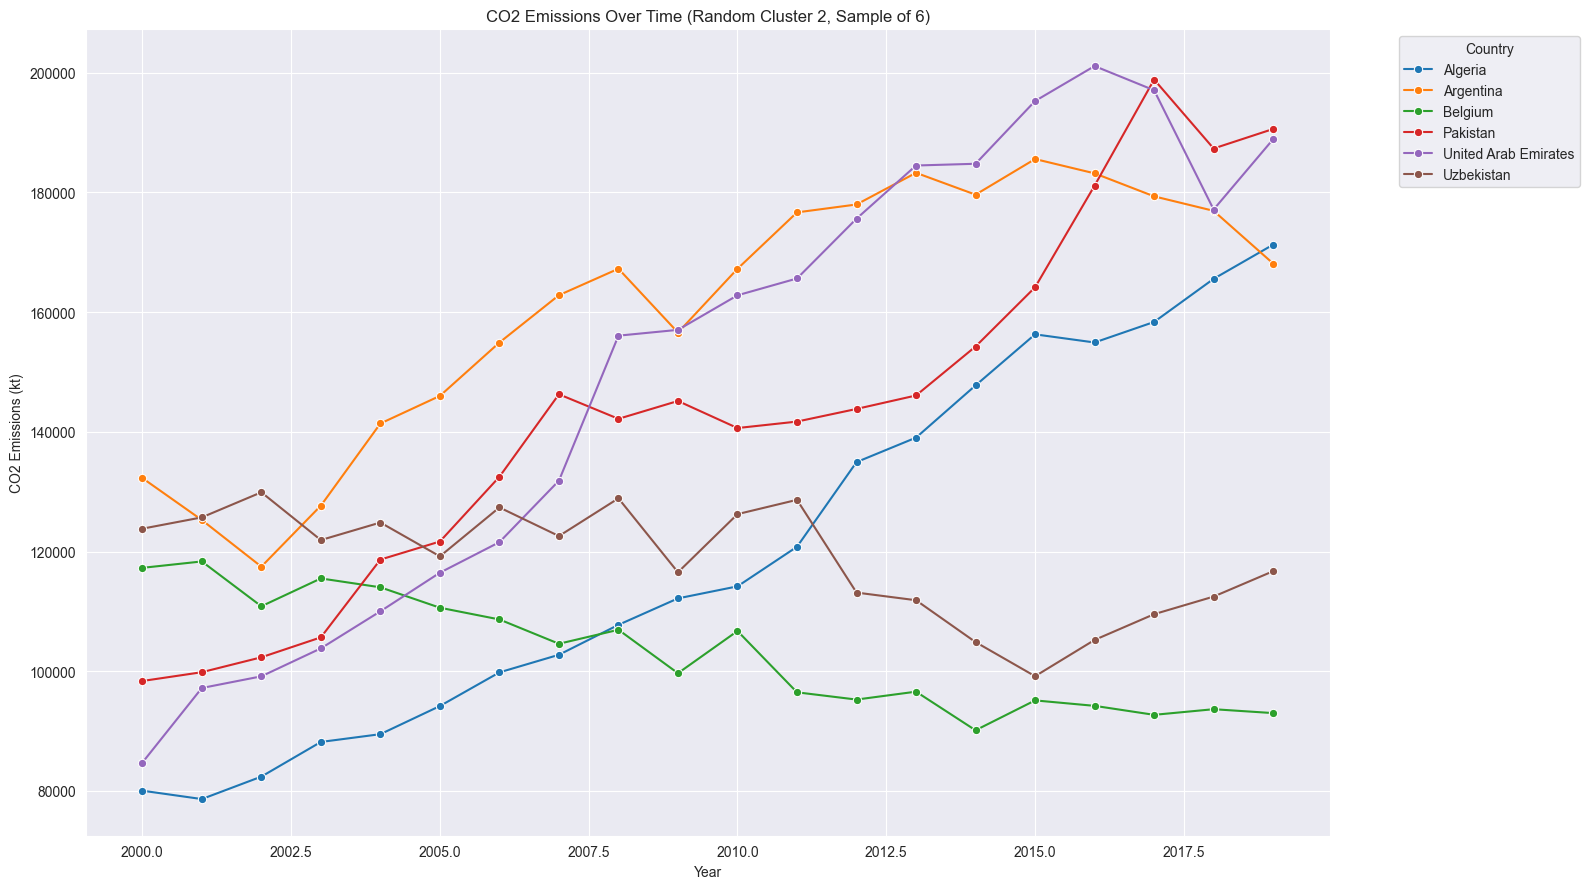

In [83]:
import random

# 1. Get valid cluster IDs
cluster_ids = filtered_avg['Cluster'].unique().tolist()

# 2. Pick one cluster at random
selected_cluster = random.choice(cluster_ids)

# 3. Get countries in that cluster
countries_in_cluster = filtered_avg[filtered_avg['Cluster'] == selected_cluster]['Entity'].tolist()

# 4. Randomly sample up to 6 countries
sampled_countries = random.sample(countries_in_cluster, k=min(6, len(countries_in_cluster)))

# 5. Filter full CO2 dataset
df_sample = df_co2_clustered[df_co2_clustered['Entity'].isin(sampled_countries)]

# 6. Plot
sns.set_style("darkgrid")
plt.figure(figsize=(16, 9))
sns.lineplot(
    data=df_sample,
    x='Year',
    y='CO2 Emissions',
    hue='Entity',
    marker='o'
)

plt.title(f"CO2 Emissions Over Time (Random Cluster {selected_cluster}, Sample of {len(sampled_countries)})")
plt.xlabel("Year")
plt.ylabel("CO2 Emissions (kt)")
plt.legend(title='Country', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# CO2 Emissions Analysis: Climate Policy Intelligence

## Methodological Sophistication

This specialized CO2 emissions analysis demonstrates advanced clustering techniques specifically designed for climate data challenges:

### **Robust Clustering Approach**
The multi-step methodology addresses real-world data issues through outlier filtering, adaptive cluster sizing, and consolidation of small groups. This approach ensures that emission clusters represent meaningful country archetypes rather than statistical artifacts.

### **Temporal Pattern Recognition**
By examining emissions trajectories within homogeneous clusters, we reveal how countries with similar emission profiles evolve over time, providing insights into shared drivers and potential intervention points.

## Key Climate Insights

### **Emission Archetype Identification**
The clustering reveals distinct emission profiles that correspond to different development stages, energy system characteristics, and climate policy approaches. Countries within clusters show similar emission levels and temporal patterns, suggesting shared structural factors.

### **Policy-Relevant Groupings**
The cluster-based approach creates natural groupings for climate policy design, as countries with similar emission profiles likely face comparable mitigation challenges and can benefit from shared strategies and peer learning.

### **Trajectory Analysis**
Examining emissions over time within clusters reveals whether countries are following convergent or divergent paths, informing expectations about future emission scenarios and the effectiveness of different policy approaches.

## Strategic Applications

This emissions clustering framework enables:
- **Differentiated climate policies** tailored to specific emission archetypes rather than one-size-fits-all approaches
- **Peer learning networks** connecting countries with similar emission profiles for knowledge sharing and collaborative mitigation strategies  
- **Progress monitoring** using cluster membership to track countries' transitions between emission categories over time
- **Investment prioritization** focusing resources on countries and clusters with the greatest potential for emission reductions

## Integration with Energy Analysis

This CO2-focused analysis complements the broader energy system exploration by providing a climate lens on the patterns identified throughout the series. The emission clusters likely correlate with the energy system archetypes discovered in earlier parts, creating a comprehensive framework for understanding climate-energy-development interactions.

The combination of sophisticated clustering with temporal analysis provides actionable intelligence for accelerating global climate action through evidence-based, targeted interventions.

## Cluster-Specific Emissions Dynamics

The random cluster sampling reveals homogeneous emissions behavior within similar country groups:
- **Within-cluster coherence** - countries in the same emission cluster show similar temporal patterns, validating the clustering approach and revealing shared emission dynamics among similar emitters
- **Policy-relevant groupings** - examining emissions trajectories within clusters provides insights for targeted climate policies, as countries with similar emission profiles likely face comparable mitigation challenges and opportunities